# Import Packages

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy.stats import ks_2samp
from scipy.stats import wilcoxon

from utils_file.tools import load_cache_file, rank_finder
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")
path = "figure_file"

# Load Data

In [3]:
stable_pairs = load_cache_file("data_file/static_strategy/ap_reward_result_test.pkl")

# Comparison Target: Reduced S&P500 constituent

In [4]:
test_data = pd.read_csv("data_file/test.csv", encoding="UTF-8")
tickers = test_data["Ticker"].unique()

In [5]:
# Add daily log return to the original stock price data
BB_value = []

for ticker in tickers:
    temp = test_data[test_data["Ticker"] == ticker]
    temp["ma_line"] = temp["Close"].rolling(window=5).mean()
    std = temp["Close"].rolling(window=5).std()
    temp["upper_bound"] = temp["ma_line"] + std
    temp["lower_bound"] = temp["ma_line"] - std
    temp["log_rtn"] = np.log(temp["Close"] / temp["Close"].shift(1))
    temp = temp.dropna()
    BB_value.append(temp)

test_append = pd.concat(BB_value, ignore_index=True)

In [6]:
# Divide the stock price data of individual stocks according to each month
split_test = {}

unique_years = test_append["Year"].unique()
unique_months = test_append["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test[f"state_{idx}"] = {}

        date_mask = (test_append["Year"] == year) & (test_append["Month"] == month)
        mask_table = test_append[date_mask]

        for ticker in tickers:
            split_test[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ]

        idx += 1

In [7]:
# 每一支成分股都執行一次 B&H 交易策略
trading_result_BandH = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        all_ticker_reward.append(split_test[state][ticker]["log_rtn"].sum())

    trading_result_BandH[state] = all_ticker_reward

In [8]:
trading_table_BandH = pd.DataFrame(trading_result_BandH, index=tickers)
stable_pairs_table = pd.DataFrame(stable_pairs).T

In [9]:
trading_table_BandH.columns = stable_pairs_table.columns
plot_data_merge = pd.concat([stable_pairs_table, trading_table_BandH], axis=0)
plot_data_merge["type"] = ["stable pairs"] * len(stable_pairs_table) + ["single assets"] * len(trading_table_BandH)

plot_data_merge = plot_data_merge.melt(id_vars="type", var_name="Time", value_name="Value")
plot_data_merge["Time"] = plot_data_merge["Time"] + 1

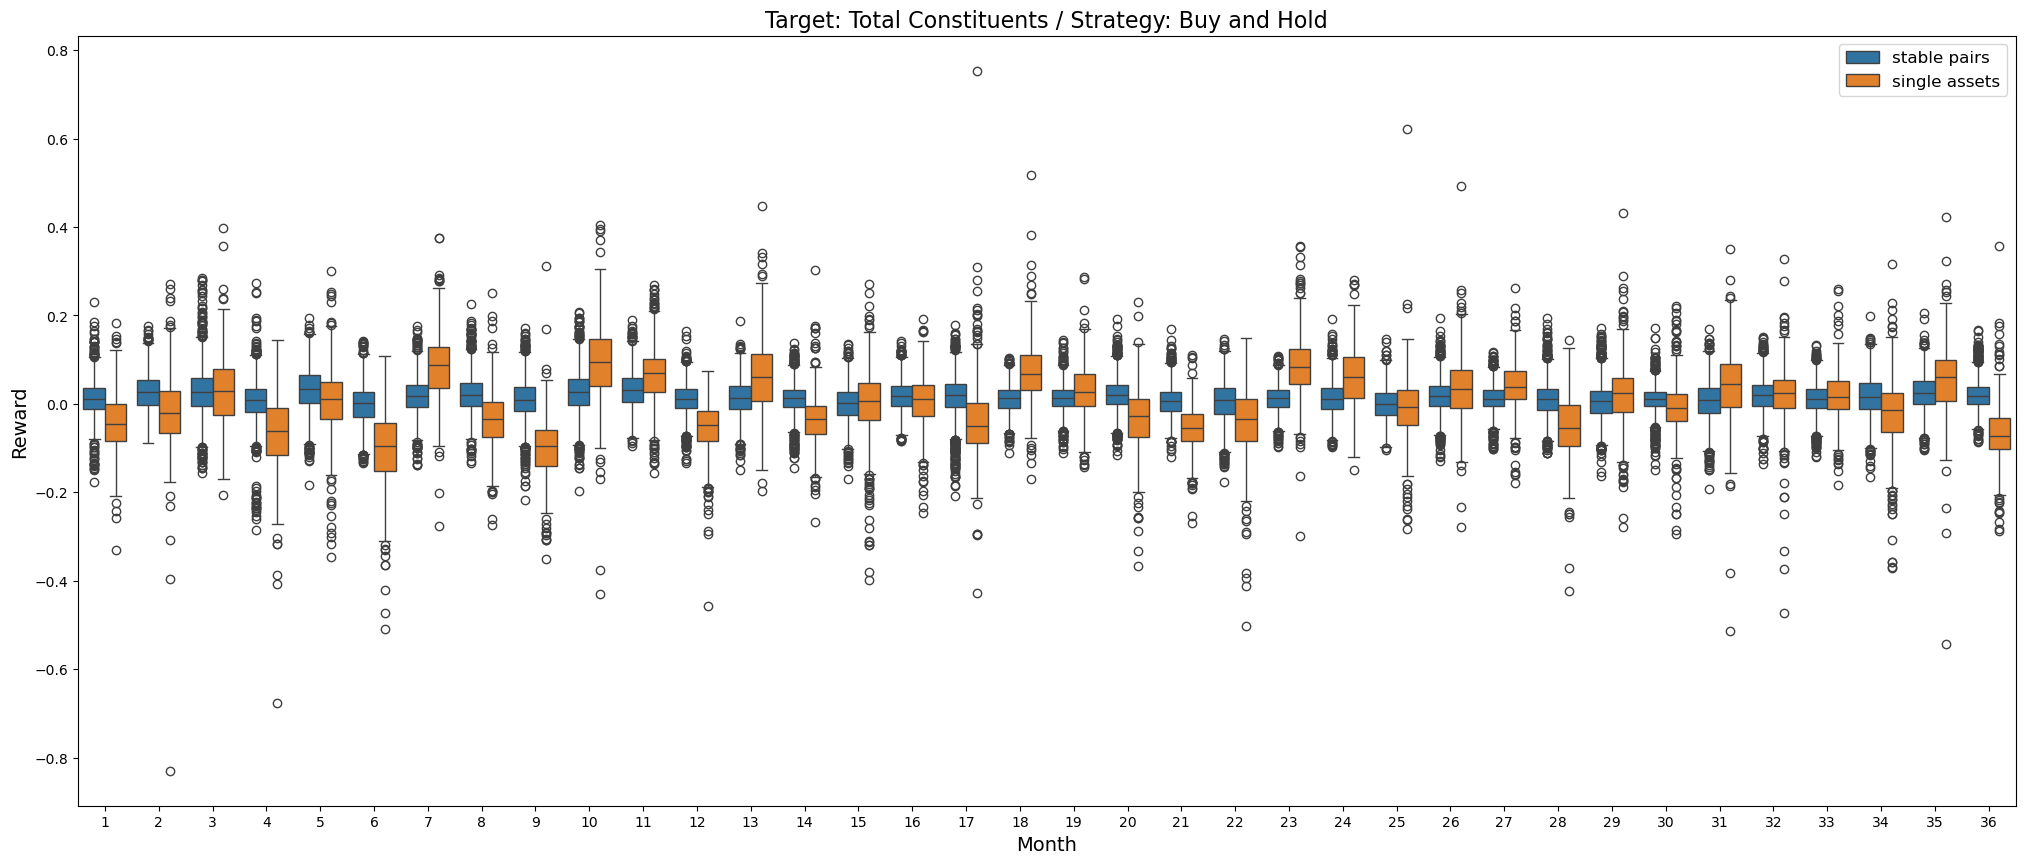

In [10]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=plot_data_merge, x="Time", y="Value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total Constituents / Strategy: Buy and Hold", fontsize=16)
plt.show()

In [11]:
stable_pairs_mean = stable_pairs_table.mean(axis=0)
trading_mean_BandH = trading_table_BandH.mean(axis=0)

trading_table_BandH_temp = trading_table_BandH.copy()
trading_table_BandH_temp.columns = [f"state_{x}" for x in range(1, 37)]

pairs_vs_BandH_rank = rank_finder(stable_pairs_mean, trading_table_BandH_temp)
trading_rank_BandH = rank_finder(trading_mean_BandH, trading_table_BandH_temp)

WRS = wilcoxon(pairs_vs_BandH_rank, trading_rank_BandH, alternative="less")
print(f"p-value (based on BandH result): {WRS[1]: .4f}")

stable_pairs_table_temp = stable_pairs_table.copy()
stable_pairs_table_temp.columns = [f"state_{x}" for x in range(1, 37)]

BandH_vs_pairs_rank = rank_finder(trading_mean_BandH, stable_pairs_table_temp)
stable_pairs_rank = rank_finder(stable_pairs_mean, stable_pairs_table_temp)

WRS = wilcoxon(BandH_vs_pairs_rank, stable_pairs_rank, alternative="less")
print(f"p-value (based on PT result): {WRS[1]: .4f}")

p-value (based on BandH result):  0.0653
p-value (based on PT result):  0.9239


[]

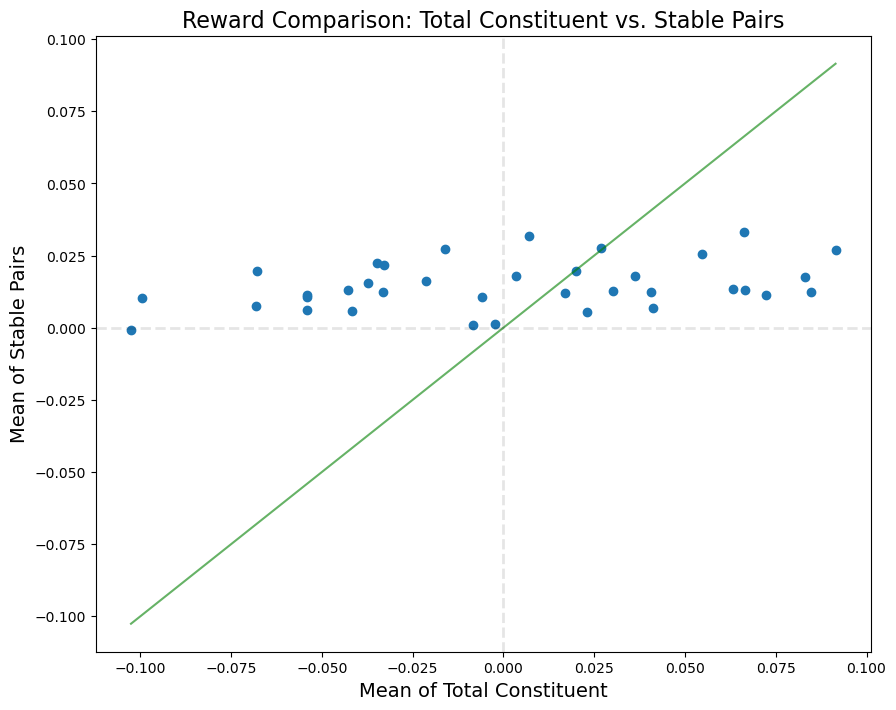

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_BandH, stable_pairs_mean)
plt.plot(
    np.linspace(
        min(min(trading_mean_BandH), min(stable_pairs_mean)),
        max(max(trading_mean_BandH), max(stable_pairs_mean)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_BandH), min(stable_pairs_mean)),
        max(max(trading_mean_BandH), max(stable_pairs_mean)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Total Constituent", fontsize=14)
plt.ylabel("Mean of Stable Pairs", fontsize=14)
plt.title("Reward Comparison: Total Constituent vs. Stable Pairs", fontsize=16)
plt.plot()

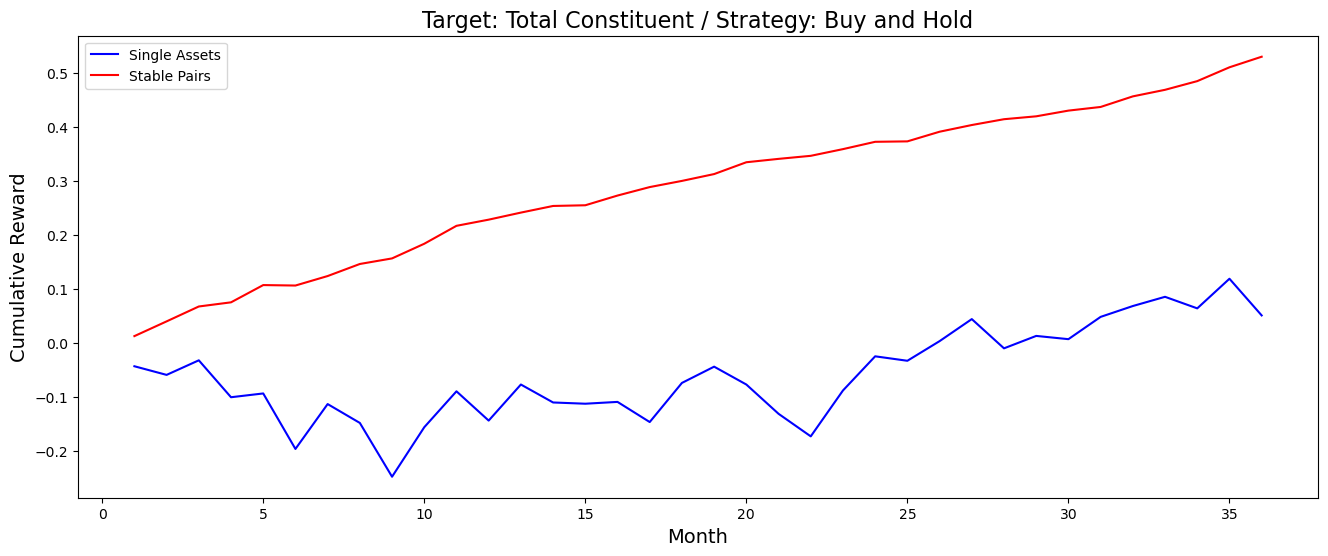

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(range(1, 37), trading_mean_BandH.cumsum(), color="blue", label="Single Assets")
plt.plot(range(1, 37), stable_pairs_mean.cumsum(), color="red", label="Stable Pairs")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.legend()
plt.title("Target: Total Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()

In [51]:
print(mean_return(stable_pairs_mean) * 100)
print(sharpe_ratio(stable_pairs_mean))
print(sortino_ratio(stable_pairs_mean))
print(profit_factor(stable_pairs_mean))
print(max_drawdown(stable_pairs_mean))
print(calmar_ratio(stable_pairs_mean))

17.64151029358758
6.119543201168697
17.64151029358758
618.8157801490295
-0.0008566393507787101
205.9385933829789
